# Compartmental models in epidemiology - Parameter estimation 

**Authors:** J.H. Cao 
<br>
**Supervisors:** prof.dr.ir. N.A.W. van Riel, dr. D. Bosnacki
<br>
**Deparment:** Biomedical Engineering, Computational Biology Group at Eindhoven University of Technology

This notebook contain the codes to model and simulate an epidemic. The focus is on **_two popular models_** used for the mathematical modelling of an infectious disease.

The two models are: 
<br>

1. **SIR model without vital dynamics, usually for the modelling of flu or epidemic**
2. **SEIRD model, above model with extra compartments "E"xposed and "D"eceased**

 More specifically, these models will be used to model the spread of **COVID-19** in the Netherlands. Furhtermore, with the **SEIR** model, it a possible to get an estimate of the number of people exposed to COVID-19 ( _this is an estimate, the true number can only be verified with testing_ ). 
<br><br>
With these models, it is also possible to analyse whether a "lockdown" has any effect on the course/spread of this virus.


## Imports packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
from scipy.optimize import curve_fit 
plt.rcParams['figure.facecolor'] = 'white'



import lmfit


import warnings
warnings.filterwarnings('ignore')

## SEIRD MODEL

In [2]:
# Define the SIR model for parameter estimation 

# Sanity check for VARIABLES:

    # S = Number of Susceptible 
    # N = Total population size 
    # I = Number of Infected (can infect others)
    # R = Number of Recovered (and assumed that they are immune to COVID-19)

# Sanity check for PARAMETERS:
    
    # (1) beta(t) = time dependent beta, is the number of people an infected person 
    # infects on average and is calculated by ( Reproductive_number(t) * gamma )
    
    # (2) gamma   =  recovery rate, an infected person recovers from this disease
    # thus it is ( 1 / the amount of days from being infected to recovered)
    

In [3]:
# Build the system in time regarding differential equations of the SEIR(D) model 

def system_sir(y, t, N, beta, gamma):
    S, I, R= y
    
    dS_dt = -beta(t) * I * (S / N)
    dI_dt = beta(t) * I * (S / N) - gamma * I 
    dR_dt = gamma * I 
    
    
    return dS_dt, dI_dt, dR_dt

# Define a logitic Reproductive number (R0) as a function of time 
# Calculate the beta(t) afterwards 

In [4]:
# Building model for the parameter estimation 

gamma = 1 / 9

def R0_function(t, R0_start, R0_end, k, x0):

    R0_val = ((R0_start - R0_end) / (1 + np.exp(-k * (-t + x0)))) + R0_end

    return R0_val

def sir_model(nrdays,pop_size, R0_start, R0_end, k, x0):
     
    
    N = pop_size
    
    def beta(t):
        time_beta = R0_function(t, R0_start, R0_end, k, x0) * gamma
        
        return time_beta
    
    S_0, I_0, R_0= N-1, 1.0, 0.0
    y_0 = S_0, I_0, R_0
    
    t_days = np.linspace(0, nrdays-1, nrdays)
    
    # Solve the differential equations 
    
    solution_sir = odeint(system_sir, y_0, t_days, args=(N, beta, gamma))
    
    S, I, R= solution_sir.T
    
    R0_values = [beta(i) / gamma for i in range(len(t_days))]
    
    return t_days, S, I, R, R0_values



## Data and Fitting

In [5]:
# Importing all data 
covid19_NL_file = './data/daily_confirmed_cases.txt'
covid19_NL_deaths = './data/corona_deaths.csv'

df_covid =  pd.read_csv(covid19_NL_file, parse_dates=['Datum']).set_index("Datum")
df_covid.head()

,Aantal
Datum,
2020-02-27,1
2020-02-28,2
2020-02-29,7
2020-03-01,10
2020-03-02,18


In [6]:
df_covid_deaths = pd.read_csv(covid19_NL_deaths, parse_dates=['Datum']).set_index("Datum")
df_covid_deaths.head()


,Aantal
Datum,
2020-02-27,0
2020-02-28,0
2020-02-29,0
2020-03-01,0
2020-03-02,0


In [7]:
pop_size = 17000000

data = df_covid["Aantal"].values
len(data)

89

In [8]:
outbreak_shift = 7

params_range = {"R0_start": (3.0, 2.0, 5.0), "R0_end": (0.9, 0.3, 3.5), "k": (2.5, 0.02, 5.0), 
                "x0": (90, 0, 120)}

nrdays = outbreak_shift + len(data)

if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, nrdays - 1, nrdays, dtype=int)

In [9]:
# Define a function for the fitting 

def sir_fit(x, R0_start, R0_end, k, x0):
    
    solution_solver = sir_model(nrdays, pop_size, R0_start, R0_end, k, x0)
    
    return solution_solver[2][x]

In [10]:
model_fitting = lmfit.Model(sir_fit)
for params_name, (init, mini, maxi) in params_range.items():
    model_fitting.set_param_hint(str(params_name), value=init, min=mini, max=maxi, vary=True)

params = model_fitting.make_params()
fit_method = "leastsq" # Using least-squares for fitting 

In [11]:
fit_results = model_fitting.fit(y_data, params, method="least_squares", x=x_data)
fit_results.best_values


{'R0_start': 4.9999999999664615,
 'R0_end': 1.019388123613425,
 'k': 0.07665678204405955,
 'x0': 21.673505833737085}

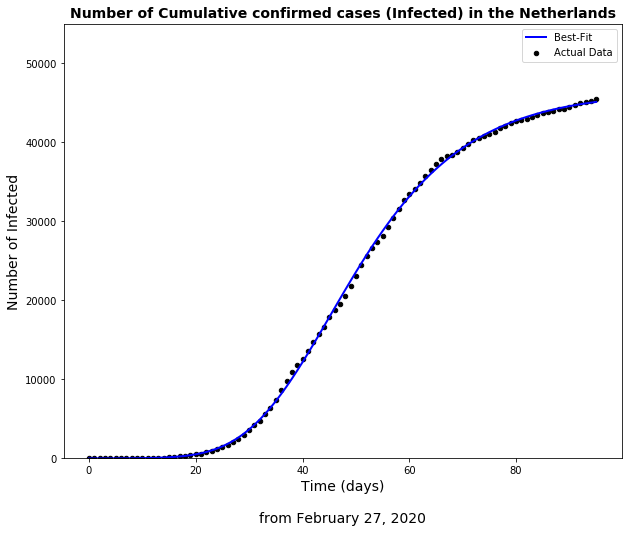

In [12]:
plt.figure(figsize=(10,8))
plt.scatter(x_data, y_data, s=20, color='k')
plt.plot(x_data, fit_results.best_fit, color='b', lw=2)
plt.ylim([0, 55000])
plt.xlabel("Time (days)" + "\n\n" + "from February 27, 2020", fontsize=14)
plt.ylabel("Number of Infected", fontsize=14)
plt.legend(["Best-Fit", "Actual Data"])
plt.title("Number of Cumulative confirmed cases (Infected) in the Netherlands", fontsize=14, weight='bold');
plt.savefig("best-fit_SIR-F.png")
# fit_results

In [13]:
final_solution = sir_model(len(x_data), 17000000, 2.49, 1.03, 0.10, 63.7)
S, I, R, R_values = final_solution[1], final_solution[2], final_solution[3], final_solution[4]

In [14]:
fit_results

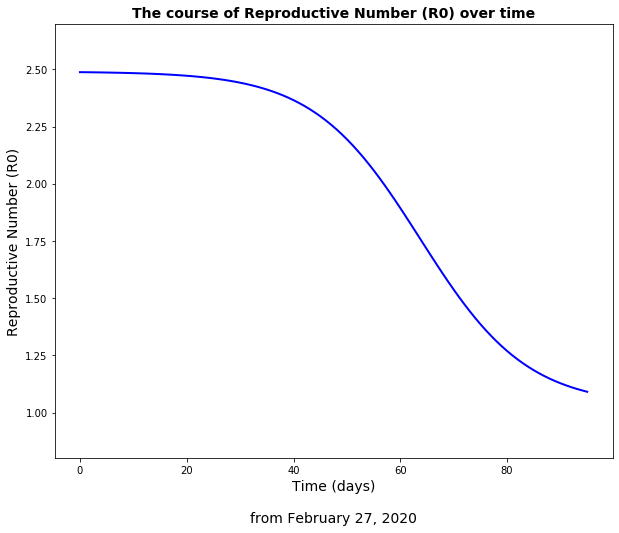

In [15]:
plt.figure(figsize=(10,8))
plt.plot(x_data, R_values,'-',color='b', lw=2)
plt.ylim([0.8, 2.7])
plt.xlabel("Time (days)" + "\n\n" + "from February 27, 2020", fontsize=14)
plt.ylabel("Reproductive Number (R0)", fontsize=14)
plt.title("The course of Reproductive Number (R0) over time", fontsize=14, weight='bold');


In [16]:
beta_values = []

for i in R_values:
    bb = i * gamma
    beta_values.append(bb)

In [18]:
def plot_sirmodel(t, S, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,5))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    
  ax.set_xlabel("Time (days)" + "\n\n" + "from February 27, 2020", fontsize=15)
  ax.set_ylabel("Number of people", fontsize=15)
  ax.set_title("SIR model", fontsize=20, weight='bold')
  
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.tick_params(axis='both', which='major', labelsize=14)
  
  legend = ax.legend()
  legend.get_frame().set_alpha(1.0)
#   plt.savefig("sir_simulation.png")
  
  plt.show();

In [1]:
t_sim, S_sim, I_sim, R_sim, R_values_sim = sir_model(96, 17000000, 5.00, 1.02, 0.08, 21.7)

plot_sirmodel(t_sim, S_sim, I_sim, R_sim)